In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

drive/  sample_data/


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
train = pd.read_csv("/content/drive/MyDrive/7313Project/train_reduced.csv")
testn = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
target = pd.read_csv("/content/drive/MyDrive/7313Project/target.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train.drop(train.iloc[:, [0,1]], axis=1, inplace=True)
test.drop(test.iloc[:, [0,1]], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:
train['is_cup'] = labelencoder.fit_transform(train['is_cup'])
test['is_cup'] = labelencoder.fit_transform(test['is_cup'])
target['target'].replace({"home": 0, "draw": 1, "away":2}, inplace=True)
train.drop(train.filter(regex='recorded_matches').columns, axis=1, inplace = True)
test.drop(test.filter(regex='recorded_matches').columns, axis=1, inplace = True)
train_x = train.copy()
train_y = target['target'].copy()
train_x.fillna(train_x.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
#fit scaler on training data
norm = StandardScaler().fit(train_x)
#transform training data
xtrain_norm = norm.transform(train_x)
#transform testing data
test_norm = norm.transform(test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    xtrain_norm, train_y, test_size=0.3, random_state=1, stratify=train_y)

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=3, 
                              random_state=1)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = np.mean(y_pred == y_test)*100
acc

47.530196502614025

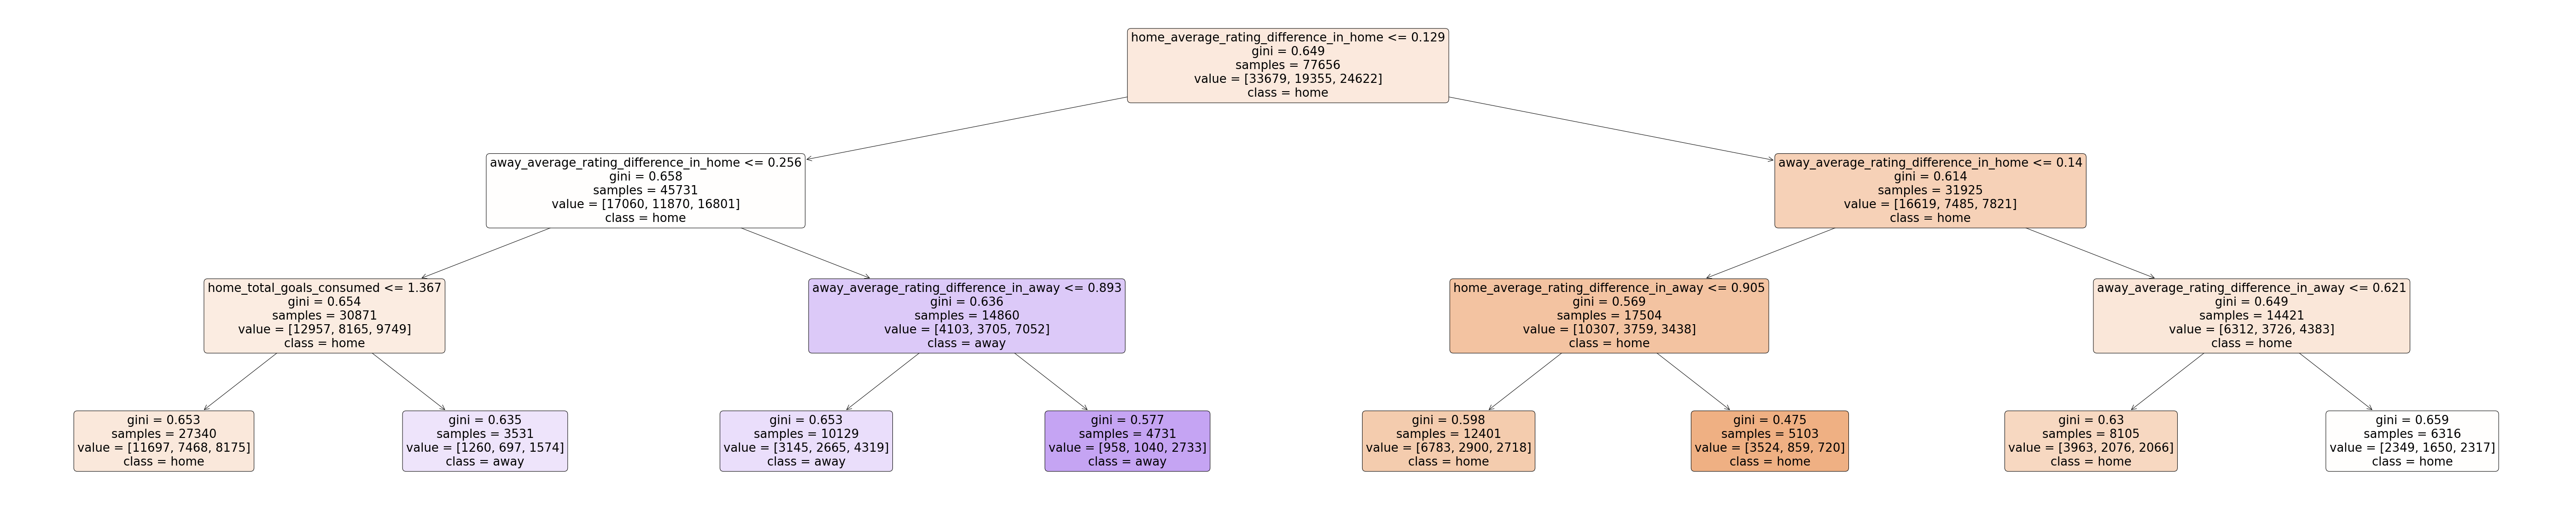

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 20))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          class_names=['home', 
                       'draw',
                       'away'],
          feature_names=train_x.columns) 

plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=5)

gs.fit(xtrain_norm, train_y)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
gs.cv_results_

Best Accuracy: 48.20%
Best Params: {'criterion': 'entropy', 'max_depth': 7}


{'mean_fit_time': array([ 2.92767863,  3.74141893,  4.54656522,  6.16851518,  5.92107615,
         6.64653125,  7.22012932,  7.86713984, 14.04238458,  4.35226047,
         5.68202813,  7.04333467,  8.38286583,  9.57841532, 10.61099961,
        11.78520527, 12.92695036, 25.77426069]),
 'mean_score_time': array([0.00757194, 0.00911138, 0.00910466, 0.01089835, 0.01140397,
        0.00769932, 0.0125936 , 0.0128058 , 0.02188354, 0.01059246,
        0.01001058, 0.01222506, 0.01276319, 0.01136017, 0.01169922,
        0.01208839, 0.01153347, 0.01890092]),
 'mean_test_score': array([0.4707766 , 0.47838446, 0.48160246, 0.4814312 , 0.48120585,
        0.48054784, 0.47786165, 0.47243516, 0.38831606, 0.47180418,
        0.47979967, 0.48080925, 0.48159342, 0.48198104, 0.48093541,
        0.47919572, 0.47372417, 0.39078592]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                    'gini', 'gini', 'entropy', 'entropy', 'entropy',
             

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=7, 
                              random_state=2)
cc = CalibratedClassifierCV(tree, cv=10)
cc.fit(xtrain_norm, train_y)
y_pred = cc.predict(xtrain_norm)
train_acc = np.mean(y_pred == train_y)*100
train_acc

49.4970163514756

In [ ]:
from mlxtend.evaluate import confusion_matrix
confmat = confusion_matrix(train_y, y_pred)

print(confmat)

[[40751     0  7362]
 [20757     1  6893]
 [21015     0 14159]]


In [ ]:
prediction_1 = cc.predict_proba(test_norm)
prediction_1

array([[0.37100823, 0.29787334, 0.33111843],
       [0.41887936, 0.30056908, 0.28055156],
       [0.39420306, 0.28890829, 0.31688864],
       ...,
       [0.38278777, 0.27128632, 0.34592591],
       [0.55404427, 0.24527483, 0.20068089],
       [0.35243954, 0.27559172, 0.37196875]])

In [ ]:
submission = pd.concat([pd.DataFrame(testn['id']), pd.DataFrame(prediction_1, columns=['home', 'draw', 'away'])[['home', 'draw', 'away']]], axis=1)
submission.to_csv('/content/drive/MyDrive/7313Project/submission.csv', index=False)